In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install plantcv

In [ ]:
import os
import glob
from plantcv import plantcv as pcv
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd

#Initial Processing


4384 6576 3


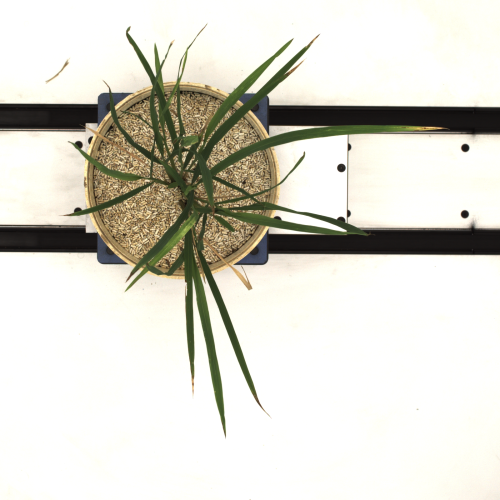

In [ ]:
path = "/content/drive/My Drive/0_0_0.png"
img = cv2.imread(path)
height, width, channels = img.shape
print(height, width, channels)
y = int(height/2-1000) 
x = int(width/2-1000)
crop_img = img[y+400:y+2000, x+400:x+2000]
resized_img = cv2.resize(crop_img, (500,500), interpolation = cv2.INTER_AREA)
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
#cv2.circle(resized_img, (182,182), 103, (255,0,0), 1)
cv2_imshow(resized_img)

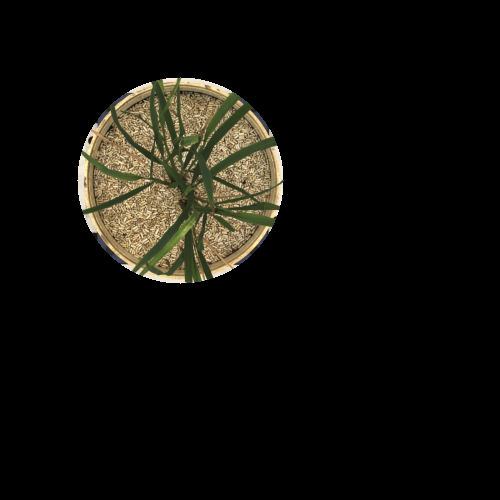

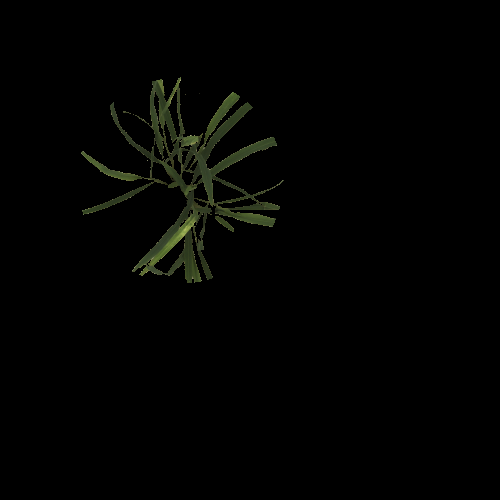

In [ ]:
height,width, channels = resized_img.shape
mask = np.zeros((height,width), np.uint8)
circle_img = cv2.circle(mask,(180,180),103,(255,255,255),thickness=-1)
masked_data = cv2.bitwise_and(resized_img, resized_img, mask=circle_img)
cv2_imshow(masked_data)
mask1, masked_img1 = pcv.threshold.custom_range(img=masked_data, lower_thresh=[30,60,20], upper_thresh=[70,255,220], channel='HSV')
cv2_imshow(masked_img1)

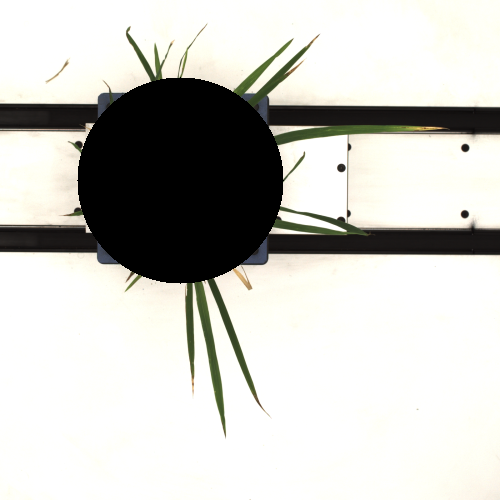

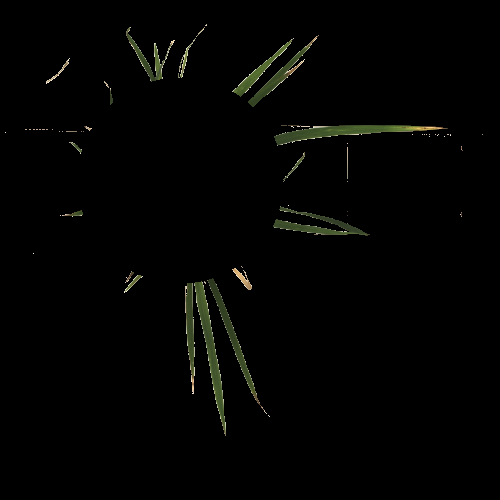

In [ ]:
mask = np.ones((height,width), np.uint8)*255
circle_img = cv2.circle(mask,(180,180),103,(0,0,0),thickness=-1)
masked_data = cv2.bitwise_and(resized_img, resized_img, mask=circle_img)
cv2_imshow(masked_data)
mask2, masked_img2 = pcv.threshold.custom_range(img=masked_data, lower_thresh=[0,0,140], upper_thresh=[255,255,255], channel='LAB')
cv2_imshow(masked_img2)

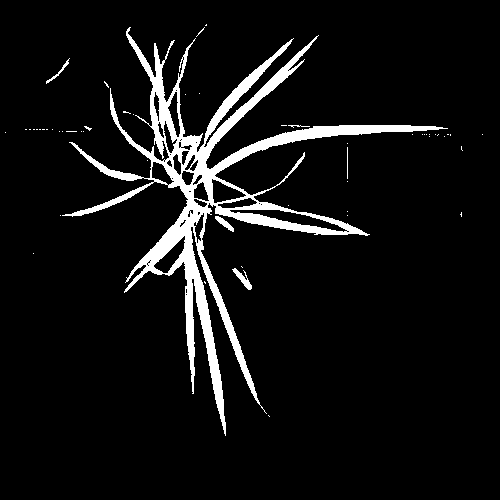

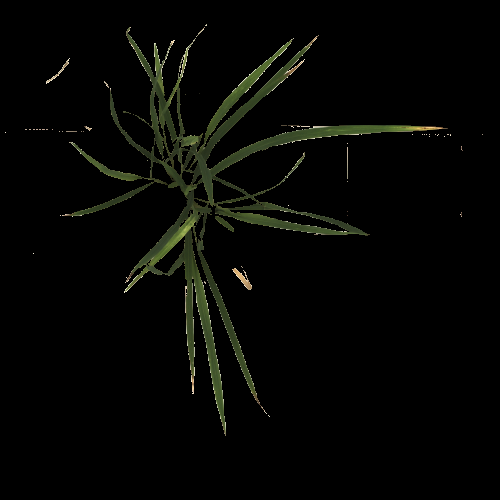

In [ ]:
final_mask = mask1 + mask2
final_img = masked_img1 + masked_img2
cv2_imshow(final_mask)
cv2_imshow(final_img)

#For filtering out small contours

27


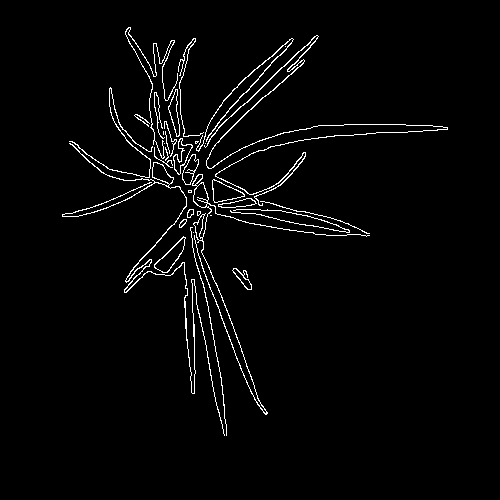

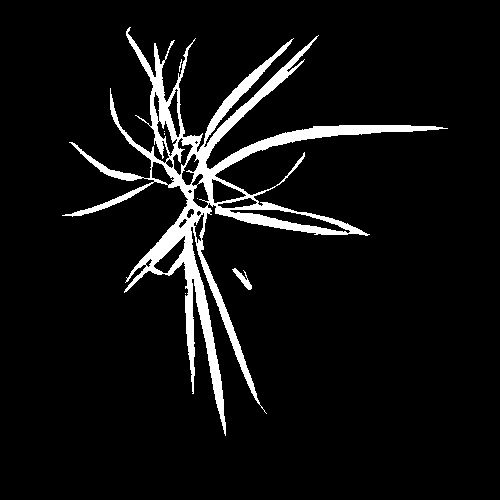

In [ ]:
im, contours, hier = cv2.findContours(final_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
mask = np.ones(im.shape[:2], dtype='uint8') * 255
for cnt in contours:
  area = cv2.contourArea(cnt)
  if area < 100:
    cv2.drawContours(mask, [cnt], -1, 0, -1)
im = cv2.bitwise_and(im, im, mask=mask)
edges = pcv.canny_edge_detect(im)
im, contours, hier = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
cv2_imshow(edges)
#cv2_imshow(mask)
cv2_imshow(im)

#Convex Hull/ Bounding Box, Circle, Ellipse

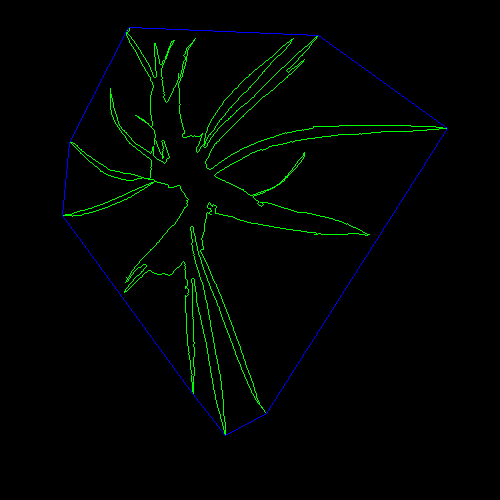

In [ ]:
im, contours, hier = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# create hull array for convex hull points
hull = []
color_contours = (0, 255, 0) # green - color for contours
color = (255, 0, 0) # blue - color for convex hull
# calculate points for each contour
for i in range(len(contours)):
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(contours[i], False))# create an empty black image
drawing = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
# draw contours and hull points
#for i in range(len(contours)):
    # draw ith contour   
#    cv2.drawContours(drawing, contours, i, color_contours,1)
    # draw ith convex hull object
#    cv2.drawContours(drawing, hull, i, color, 1)
cv2.drawContours(drawing, contours, 3, color_contours,1)
cv2.drawContours(drawing, hull, 3, color, 1)
cv2_imshow(drawing)

# Bounding Box

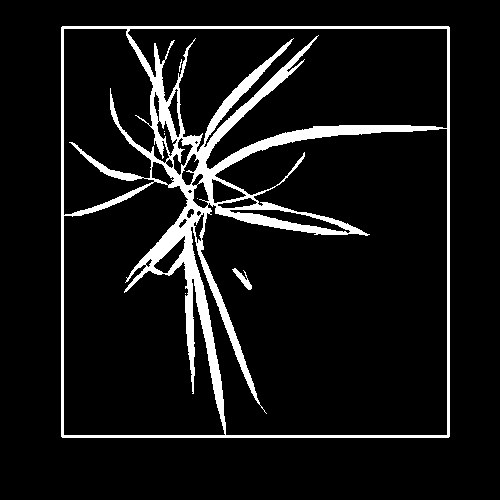

In [ ]:
w_max,h_max = 0,0
im, contours, hier = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
drawing = np.zeros((im.shape[0], im.shape[1]), np.uint8) + im
for i in range(len(contours)):
  x,y,w,h = cv2.boundingRect(contours[i])
  if w_max<w and h_max<h:
    #print(i)
    x_max,y_max,w_max,h_max = x,y,w,h
drawing = cv2.rectangle(drawing,(x_max,y_max),(x_max+w_max,y_max+h_max),(255,255,255),2)
cv2_imshow(drawing)

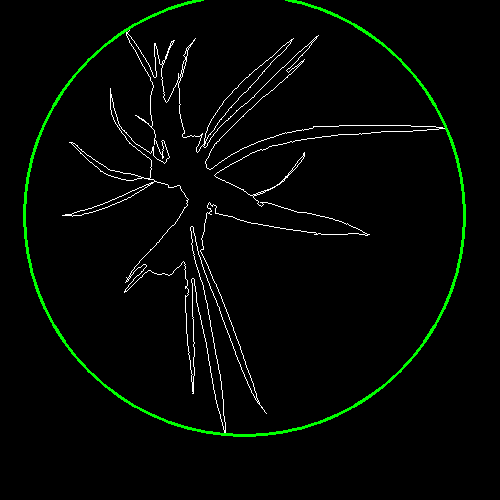

In [ ]:
_, contours, _ = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
minEllipse = [None]*len(contours)
drawing = np.zeros((500,500, 3), dtype=np.uint8) 
(x,y),radius = cv2.minEnclosingCircle(contours[3])
center = (int(x),int(y))
radius = int(radius)
cv2.drawContours(drawing, contours, 3, color)
cv2.circle(drawing,center,radius,(0,255,0),2)
cv2_imshow(drawing)

#Extra Processing (To be updated)

In [ ]:
def find_if_close(cnt1, cnt2):
    # Merging contour based on distance between contours
    row1, row2 = cnt1.shape[0], cnt2.shape[0]
    for i in xrange(row1):
        for j in xrange(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < 50:
                return True
            elif i == row1-1 and j == row2-1:
                return False


def merging_close_cont():
    im = delete_small_cont()
    # Merging close contour
    _, contours, hier = cv2.findContours(im, cv2.RETR_EXTERNAL, 2)
    length = len(contours)
    #print length
    if length < 4: # There is no 4 red dots available on the image
        return '0'
    else:
        status = np.zeros((length, 1))
        for i, cnt1 in enumerate(contours):
            x = i
            if i != length-1:
                for j, cnt2 in enumerate(contours[i+1:]):
                    x += 1
                    dist = find_if_close(cnt1, cnt2)
                    if dist is True:
                        val = min(status[i], status[x])
                        status[x] = status[i] = val
                    else:
                        if status[x] == status[i]:
                            status[x] = i+1

        unified = []
        maximum = int(status.max())+1
        for i in xrange(maximum):
            pos = np.where(status == i)[0]
            if pos.size != 0:
                cont = np.vstack(contours[i] for i in pos)
                hull = cv2.convexHull(cont)
                unified.append(hull)

        #cv2.drawContours(im,unified,-1,(0,255,0),2)
        #cv2.drawContours(thresh,unified,-1,255,-1)
        cv2.drawContours(im, unified, -1, 255, -1)

        #cv2.imshow('thresh2', thresh)
        #cv2.imshow('uni image', im)
        #cv2.imwrite('uni.png', im)
        return im

#Side Image Operation

6576 4384 3
(1760, 2100, 3)


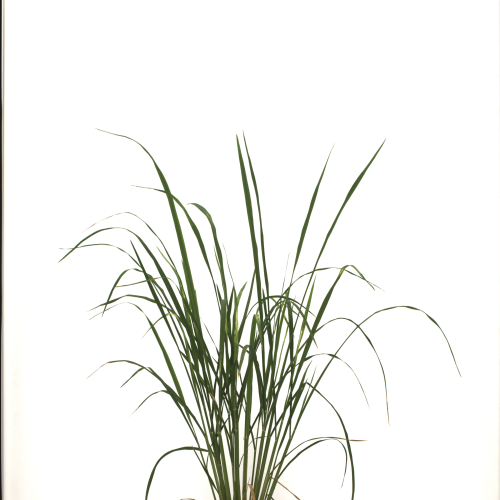

In [ ]:
path_side="/content/drive/My Drive/Annotated_Data_BB/train7S remaining/39.png"
img = cv2.imread(path_side)
height, width, channels = img.shape
print(height, width, channels)
y = int(height/2-1000) 
x = int(width/2-1000)
crop_img = img[y-500:y+1260, x-50:x+2050]
print(crop_img.shape)
resized_img = cv2.resize(crop_img, (500,500), interpolation = cv2.INTER_AREA)
gray_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
cv2_imshow(resized_img)

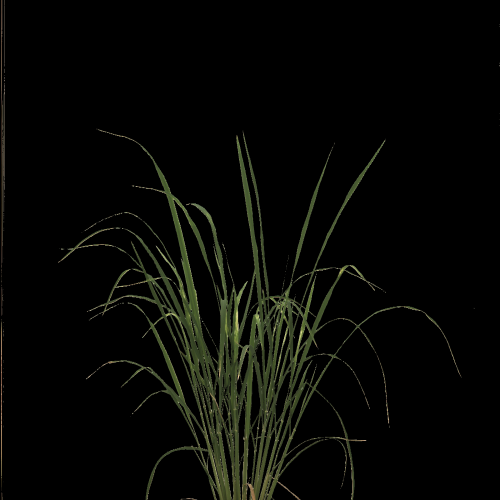

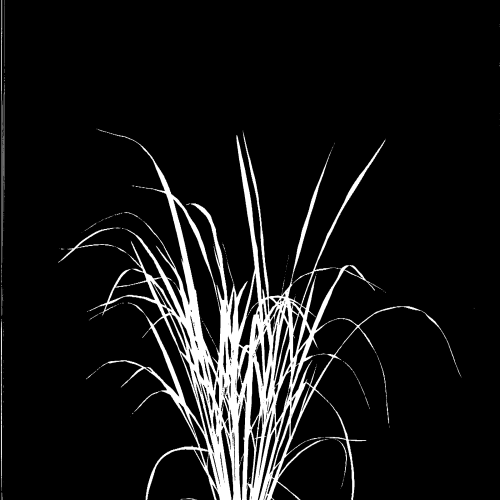

In [ ]:
mask1, masked_img1 = pcv.threshold.custom_range(img=crop_img, lower_thresh=[36,20,20], upper_thresh=[70,255,255], channel='HSV')
masked_img1 = cv2.resize(masked_img1, (500,500), interpolation = cv2.INTER_AREA)
mask1 = cv2.resize(mask1, (500,500), interpolation = cv2.INTER_AREA)
mask2, masked_img2 = pcv.threshold.custom_range(img=crop_img, lower_thresh=[0,0,140], upper_thresh=[255,255,255], channel='LAB')
masked_img2 = cv2.resize(masked_img2, (500,500), interpolation = cv2.INTER_AREA)
mask2 = cv2.resize(mask2, (500,500), interpolation = cv2.INTER_AREA)
cv2_imshow(masked_img2)
cv2_imshow(mask2)

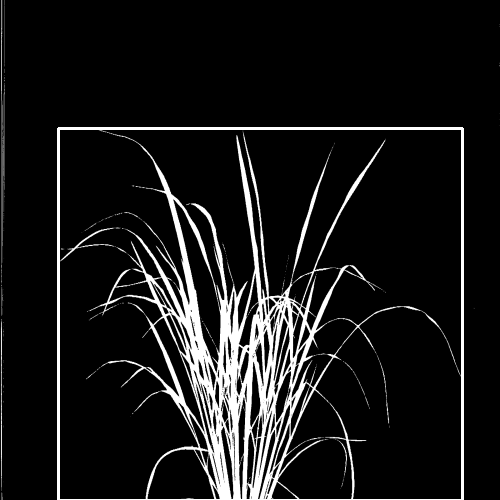

In [ ]:
w_max,h_max = 0,0
i, contours, hier = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
drawing = np.zeros((mask2.shape[0], mask2.shape[1]), np.uint8) + mask2
for i in range(len(contours)):
  x,y,w,h = cv2.boundingRect(contours[i])
  if w_max<w and h_max<h:
    x_max,y_max,w_max,h_max = x,y,w,h
    i_max = i
drawing = cv2.rectangle(drawing,(x_max,y_max),(x_max+w_max,y_max+h_max),(255,255,255),2)
cv2_imshow(drawing)

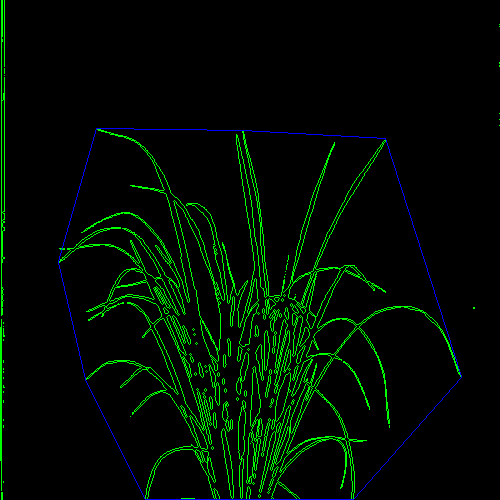

11
[97, 243, 385, 461, 461, 353, 145, 85, 58, 58, 96]
403 371


In [ ]:
im, contours, hier = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hull = []
color_contours = (0, 255, 0) 
color = (255, 0, 0)
hull.append(cv2.convexHull(contours[i_max], False))
hull1 = cv2.convexHull(contours[i_max])
drawing = np.zeros((mask2.shape[0], mask2.shape[1], 3), np.uint8)
for i in range(len(contours)):
    cv2.drawContours(drawing, contours, i, color_contours,1)
cv2.drawContours(drawing, hull, 0, color, 1)
cv2_imshow(drawing)
print(len(hull1))
x = [hull1[i][0][0] for i in range(len(hull1))]
y = [hull1[i][0][1] for i in range(len(hull1))]
print(x)
width = np.max(x) - np.min(x)
height = np.max(y) - np.min(y)
print(width,height)

In [ ]:
print(w_max,h_max)

373 456


In [ ]:
class MyImage:
    def __init__(self, img_name):
        self.img = cv2.imread(img_name)
        self.__name = img_name 
    def __str__(self):
        return self.__name

In [ ]:
data = pd.DataFrame(columns=["ImageID", "Height", "Width"])
for imgs in glob.glob("/content/drive/My Drive/Annotated_Data_BB/train7S remaining/*.png"):
  #img = MyImage(imgs)
  #print(os.path.basename(str(cv_img)))
  img = cv2.imread(imgs) 
  height, width, channels = img.shape
  y = int(height/2-1000) 
  x = int(width/2-1000)
  crop_img = img[y-500:y+1260, x-50:x+2050]
  resized_img = cv2.resize(crop_img, (500,500), interpolation = cv2.INTER_AREA)
  gray_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
  #cv2_imshow(resized_img)
  mask2, masked_img2 = pcv.threshold.custom_range(img=crop_img, lower_thresh=[0,0,140], upper_thresh=[255,255,255], channel='LAB')
  masked_img2 = cv2.resize(masked_img2, (500,500), interpolation = cv2.INTER_AREA)
  mask2 = cv2.resize(mask2, (500,500), interpolation = cv2.INTER_AREA)
  w_max,h_max = 0,0
  i, contours, hier = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    if w_max<w and h_max<h:
      x_max,y_max,w_max,h_max = x,y,w,h
      i_max = i
  im, contours, hier = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  hull = []
  color_contours = (0, 255, 0) 
  color = (255, 0, 0)
  hull.append(cv2.convexHull(contours[i_max], False))
  hull1 = cv2.convexHull(contours[i_max])
  drawing = np.zeros((mask2.shape[0], mask2.shape[1], 3), np.uint8)
  for i in range(len(contours)):
    cv2.drawContours(drawing, contours, i, color_contours,1)
  cv2.drawContours(drawing, hull, 0, color, 1)
  #cv2_imshow(drawing)
  x = [hull1[i][0][0] for i in range(len(hull1))]
  y = [hull1[i][0][1] for i in range(len(hull1))]
  width = np.max(x) - np.min(x)
  height = np.max(y) - np.min(y)
  img1 = MyImage(imgs)
  data = data.append({"ImageID": os.path.basename(str(img1)),"Height": height, "Width": width}, ignore_index=True)

422 463
473 453
233 376
243 384
269 389
215 388
375 419
341 405
311 404
346 417
352 360
259 370
276 373
274 371
461 434
459 452
476 451
372 454
403 371
359 372
401 371
309 370


In [ ]:
data

ImageID Height Width
0   19.png    463   422
1   18.png    453   473
2   23.png    376   233
3   22.png    384   243
4   21.png    389   269
5   20.png    388   215
6   27.png    419   375
7   26.png    405   341
8   25.png    404   311
9   24.png    417   346
10  30.png    360   352
11  31.png    370   259
12  29.png    373   276
13  28.png    371   274
14  35.png    434   461
15  34.png    452   459
16  33.png    451   476
17  32.png    454   372
18  39.png    371   403
19  38.png    372   359
20  37.png    371   401
21  36.png    370   309